In [1]:
import pyrosetta 
from rosetta import protocols, core
from Bio.Data import IUPACData
from sklearn import preprocessing, linear_model, model_selection

%matplotlib inline 
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas

In [2]:
INPUT_POSE = 'input_pose.pdb'
PARAMS = 'pnpg.params'
CST_FILE = 'pnpg.cst'
TARGET = 399
NEW_RES = 'K'

In [3]:
pyrosetta.init('-beta -extra_res_fa pnpg.params -preserve_header')

Found rosetta database at: /Users/alex/anaconda3/envs/rose/lib/python3.5/site-packages/pyrosetta-4.0-py3.5.egg/database; using it....
PyRosetta-4 2016 [Rosetta 2016 unknown:94998f0e5b038b6d8083995a664cb96641cb844b 2017-05-11 15:10:16 -0500] retrieved from: git@github.com:RosettaCommons/main.git
(C) Copyright Rosetta Commons Member Institutions.
Created in JHU by Sergey Lyskov and PyRosetta Team.



In [4]:
p = pyrosetta.pose_from_file(INPUT_POSE)
s = pyrosetta.create_score_function('beta_cst')
soft_rep = pyrosetta.create_score_function('soft_rep')

In [5]:
'Score before constraints', s(p)

('Score before constraints', -1272.156077213541)

In [6]:
add_constraints = protocols.enzdes.AddOrRemoveMatchCsts()
add_constraints.cstfile(CST_FILE) 
add_constraints.set_cst_action(protocols.enzdes.CstAction.ADD_NEW)
add_constraints.apply(p)

In [7]:
'Score after constraints', s(p)

('Score after constraints', -1274.3293653061862)

In [8]:
# output a PDB file 
p.dump_scored_pdb('input_pose_0001.pdb', s)

In [9]:
new_res_three = IUPACData.protein_letters_1to3[NEW_RES].upper()
mutate = protocols.simple_moves.MutateResidue(TARGET, new_res_three) 
mutate.apply(p)

In [10]:
'Score after mutation', s(p)

('Score after mutation', -832.3176113264828)

In [11]:
# output a PDB file 
p.dump_scored_pdb('input_pose_0002.pdb', s)

In [12]:
enzyme_design = protocols.enzdes.EnzRepackMinimize()
enzyme_design.set_scorefxn_repack(soft_rep)
enzyme_design.set_scorefxn_minimize(s)
enzyme_design.set_design(False)
enzyme_design.set_min_lig(True)
enzyme_design.set_min_rb(True)
enzyme_design.set_min_sc(True)

tf = core.pack.task.TaskFactory()
task = protocols.toolbox.task_operations.DesignAroundOperation()
task.allow_design(False)
task.repack_shell(10.0)
task.include_residue(p.total_residue())
task.include_residue(TARGET)
tf.push_back(task)
pt = tf.create_task_and_apply_taskoperations(p)
enzyme_design.task_factory(tf)

In [13]:
"Nothing is designed", any([n == 1 for n in pt.designing_residues()])

('Nothing is designed', True)

In [14]:
"Number repacked", sum(pt.repacking_residues()) 

('Number repacked', 40)

In [15]:
parsed = protocols.moves.SequenceMover()
parsed.add_mover(enzyme_design) 

mc = protocols.simple_moves.GenericMonteCarloMover()
mc.set_drift(False)
mc.set_maxtrials(1)
mc.set_sampletype('low')
mc.set_temperature(0.6)
mc.set_mover(parsed)
mc.set_scorefxn(s)
mc.apply(p)

In [16]:
'Score after Monte Carlo', s(p)

('Score after Monte Carlo', -1256.258729097665)

In [17]:
# output a PDB file 
p.dump_scored_pdb('input_pose_0003.pdb', s)

In [18]:
# generate features 

def residues_with_constraints(pose):
    result = []
    for n in pose.constraint_set().get_all_constraints():
        for m in n.residues():
            result.append(m)
    return set(result) 

print(residues_with_constraints(p))

{353, 164, 446, 295}


In [19]:
print(s(p))
en = p.energies()
en.residue_total_energies(12)

-1256.258729097665


In [20]:
def get_residue_scores(pose, score_function, residues=[]):
    
    values = []
    labels = []
    if len(residues) > 0:
        residue_set = residues
    else:
        residue_set = range(1, pose.total_residue()+1) 
        # want to include lig
    score_types = score_function.get_nonzero_weighted_scoretypes()
    begin_score = score_function(pose) 
    for residue in residue_set:
        for st in score_types:
            label = '{}__{}'.format(residue, str(st).replace('ScoreType.', ''))
            labels.append(label)
            values.append(pose.energies().residue_total_energies(residue)[st])
                          
    return dict(zip(labels, values))
                          
get_residue_scores(p, s, residues_with_constraints(p))

{'164__angle_constraint': 0.01282231124127567,
 '164__atom_pair_constraint': 0.06322637546560678,
 '164__chainbreak': 0.0,
 '164__coordinate_constraint': 0.0,
 '164__dihedral_constraint': 0.0,
 '164__dslf_fa13': 0.0,
 '164__fa_atr': -10.239707482855739,
 '164__fa_dun_dev': 0.011515890076749512,
 '164__fa_dun_rot': 0.0,
 '164__fa_dun_semi': 4.080225708988196,
 '164__fa_elec': -4.746251491428072,
 '164__fa_intra_atr_xover4': -0.24549003780855677,
 '164__fa_intra_elec': -0.3589812440077575,
 '164__fa_intra_rep_xover4': 0.1123514634110579,
 '164__fa_intra_sol_xover4': 0.42214251648272044,
 '164__fa_rep': 4.499718905023112,
 '164__fa_sol': 12.214979466315551,
 '164__hbond_bb_sc': 0.0,
 '164__hbond_lr_bb': 0.0,
 '164__hbond_sc': -0.08764716704092744,
 '164__hbond_sr_bb': 0.0,
 '164__hxl_tors': 0.0,
 '164__lk_ball': 6.312237177172938,
 '164__lk_ball_bridge': 0.036621137942767,
 '164__lk_ball_bridge_uncpl': 0.2284926101078643,
 '164__lk_ball_iso': 12.807334992637557,
 '164__omega': 0.278339582

In [21]:
p.sequence()[122-1]

'L'

In [22]:
# now do for all mutants 

In [23]:
t = pandas.read_csv('../../../data_sets/speculative_targets.csv', index_col=0)
t.head()

,kcat,km,kcatkm,expression
mutant_name,,,,
S14A,-0.439333,0.217484,-0.651460,1
T15A,-0.156314,0.025306,-0.176657,1
S16A,-0.756962,0.447468,-1.199275,1
S17A,-0.016087,0.567026,-0.577999,1
S17E,-0.137625,0.165541,-0.298065,1


In [24]:
# mutant_list = ['W120K', 'D121F', 'L122I']
mutant_list = [n for n in t.index if 'gl' not in n]
len(mutant_list)

145

In [25]:
p = pyrosetta.pose_from_file(INPUT_POSE)
add_constraints.apply(p)
res_w_cst = residues_with_constraints(p)
print(res_w_cst)

def get_features(mutant_names):
    '''
    Get a dict of features for a mutant 
    given an int residue position and one-letter code
    '''

    for mutant_name in mutant_names: 
        target, new_res = int(mutant_name[1:-1]), mutant_name[-1]

        cp = p.clone()
        begin_score = s(cp)
        
        new_res_three = IUPACData.protein_letters_1to3[new_res].upper()
        mutate = protocols.simple_moves.MutateResidue(target, new_res_three) 
        mutate.apply(cp)

        mc.apply(cp)
        print(target, new_res)

        data = get_residue_scores(cp, s, residues=res_w_cst)
        yield pandas.Series(data, name=mutant_name)

df = pandas.DataFrame(get_features(mutant_list)) 
df.head()

{353, 164, 446, 295}
14 A
15 A
16 A
17 A
17 E
18 A
52 G
72 A
91 E
101 R
119 N
119 A
120 H
120 F
154 D
163 A
163 D
163 C
164 A
167 A
167 Q
171 A
171 R
175 R
177 L
177 K
177 A
178 A
192 S
218 A
220 R
220 G
220 H
220 A
220 Y
221 A
222 Y
222 K
222 R
222 H
222 Q
222 A
240 D
240 K
240 A
244 E
244 N
293 C
293 A
294 A
294 F
298 E
300 N
313 R
323 A
325 C
325 H
325 A
325 L
331 A
341 A
352 A
354 A
358 T
362 M
373 R
399 R
399 C
400 A
404 A
404 C
406 D
409 Y
415 A
423 S
227 W
167 S
164 D
388 C
153 A
244 M
244 V
108 N
171 D
163 S
220 D
220 S
293 S
313 E
406 Q
413 A
178 N
322 A
261 E
315 Y
219 A
177 S
219 A
315 Y
315 A
413 A
284 R
353 E
426 S
426 S
177 S
272 N
320 Q
12 N
16 N
19 P
32 L
34 A
76 A
119 E
120 A
121 F
163 E
163 K
164 G
164 R
166 P
178 R
236 E
240 E
249 E
261 D
293 D
293 K
294 L
296 A
296 E
315 N
323 K
325 G
329 N
343 S
355 A
379 T
403 A
407 G
407 K
407 Q
407 R
407 Y


,164__angle_constraint,164__atom_pair_constraint,164__chainbreak,164__coordinate_constraint,164__dihedral_constraint,164__dslf_fa13,164__fa_atr,164__fa_dun_dev,164__fa_dun_rot,164__fa_dun_semi,...,446__lk_ball,446__lk_ball_bridge,446__lk_ball_bridge_uncpl,446__lk_ball_iso,446__omega,446__p_aa_pp,446__pro_close,446__rama_prepro,446__ref,446__res_type_constraint
S14A,0.012970,0.078481,0.0,0.0,0.0,0.0,-10.250947,0.030694,0.0,4.103605,...,7.298455,0.106166,1.147538,11.376636,0.0,0.0,0.0,0.0,0.0,0.0
T15A,0.010381,0.078165,0.0,0.0,0.0,0.0,-10.251867,0.007407,0.0,4.092553,...,7.329897,0.109665,1.192606,11.393193,0.0,0.0,0.0,0.0,0.0,0.0
S16A,0.015946,0.078630,0.0,0.0,0.0,0.0,-10.243117,0.059116,0.0,4.108807,...,7.265003,0.092247,0.837597,11.385112,0.0,0.0,0.0,0.0,0.0,0.0
S17A,0.010063,0.078299,0.0,0.0,0.0,0.0,-10.251832,0.007014,0.0,4.092000,...,7.330956,0.109893,1.196544,11.394173,0.0,0.0,0.0,0.0,0.0,0.0
S17E,0.010174,0.078050,0.0,0.0,0.0,0.0,-10.251807,0.007014,0.0,4.091980,...,7.330572,0.109845,1.195681,11.394373,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
print(df.shape)
dropme = []
for column in df:
    if df[column].std() == 0.0:
        dropme.append(column)
df = df.drop(dropme, axis=1) 
scaler = preprocessing.StandardScaler()
df = pandas.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
print(df.shape) 

(145, 128)
(145, 85)


In [27]:
df.head()

,164__angle_constraint,164__atom_pair_constraint,164__dihedral_constraint,164__fa_atr,164__fa_dun_dev,164__fa_dun_rot,164__fa_dun_semi,164__fa_elec,164__fa_intra_atr_xover4,164__fa_intra_elec,...,446__fa_intra_elec,446__fa_intra_rep_xover4,446__fa_intra_sol_xover4,446__fa_rep,446__fa_sol,446__hbond_sc,446__lk_ball,446__lk_ball_bridge,446__lk_ball_bridge_uncpl,446__lk_ball_iso
S14A,-0.094261,-0.090204,-0.100232,-0.149420,-0.087530,-0.083333,0.156782,-0.184508,-0.008853,-0.172869,...,0.215520,0.011824,-0.109961,-0.181700,0.143280,-0.456626,0.183466,0.045741,0.015662,0.143594
T15A,-0.094295,-0.090208,-0.100232,-0.150709,-0.114339,-0.083333,0.137865,-0.154046,-0.014657,0.004306,...,0.093776,0.016992,-0.169954,-0.131372,0.184260,-0.153476,0.269026,0.280540,0.291119,0.175799
S16A,-0.094222,-0.090202,-0.100232,-0.138447,-0.054810,-0.083333,0.165688,-0.110733,-0.012164,-0.172086,...,-0.363292,-0.184049,-0.097625,-0.099896,0.132019,-0.847055,0.092433,-0.888335,-1.878706,0.160081
S17A,-0.094299,-0.090207,-0.100232,-0.150660,-0.114792,-0.083333,0.136918,-0.151915,-0.015141,0.014827,...,0.089621,0.014575,-0.170088,-0.130968,0.187808,-0.141671,0.271906,0.295841,0.315187,0.177706
S17E,-0.094298,-0.090210,-0.100232,-0.150625,-0.114792,-0.083333,0.136885,-0.151363,-0.015162,0.015037,...,0.088657,0.014222,-0.170038,-0.130212,0.188361,-0.140734,0.270863,0.292632,0.309916,0.178094


In [28]:
J = t.join(df).drop(['BglB'], axis=0).drop(['expression'], axis=1).dropna()
print(J.shape) 
J.head()

(118, 88)


,kcat,km,kcatkm,164__angle_constraint,164__atom_pair_constraint,164__dihedral_constraint,164__fa_atr,164__fa_dun_dev,164__fa_dun_rot,164__fa_dun_semi,...,446__fa_intra_elec,446__fa_intra_rep_xover4,446__fa_intra_sol_xover4,446__fa_rep,446__fa_sol,446__hbond_sc,446__lk_ball,446__lk_ball_bridge,446__lk_ball_bridge_uncpl,446__lk_ball_iso
A192S,0.031408,0.007748,0.028609,-0.094300,-0.090205,-0.100232,-0.150797,-0.114954,-0.083333,0.136732,...,0.091440,0.017280,-0.172166,-0.130909,0.188277,-0.136169,0.273065,0.295817,0.313669,0.178151
A227W,-0.362874,0.531479,-0.889390,-0.094300,-0.090205,-0.100232,-0.150797,-0.114954,-0.083333,0.136732,...,0.091440,0.017280,-0.172166,-0.130909,0.188277,-0.136169,0.273065,0.295817,0.313669,0.178151
C167A,-0.264147,0.464191,-0.723565,-0.094321,-0.090270,-0.100232,0.452518,-0.110068,-0.083333,0.144153,...,-0.370710,0.144088,-0.473328,-0.125463,0.350487,-0.224857,0.443551,-0.841062,-1.170000,0.388959
C167Q,-0.242052,-0.007005,-0.230186,-0.094347,-0.067028,-0.100232,-0.607307,0.397275,-0.083333,0.526354,...,0.379252,-1.512400,1.950632,0.663768,2.362086,-0.889852,2.314721,-3.814610,-3.262867,3.207252
C167S,-0.953700,1.814514,-2.763251,-0.094201,-0.090378,-0.100232,0.314477,-0.065740,-0.083333,0.161325,...,-0.090255,-0.212403,0.016547,-0.348234,0.800175,-0.415937,0.571594,-0.194441,-0.311965,0.719093


In [29]:
targets = 'kcat km kcatkm'.split()
for target_name in targets:
    X = J.iloc[:, 3:]
    y = J[target_name]
    clf = linear_model.LassoCV(cv=10, max_iter=1e5)
    pred = clf.fit(X, y).predict(X) #model_selection.cross_val_predict(clf, X, y, cv=10)
    J['{}_prediction'.format(target_name)] = pred 

/Users/alex/anaconda3/envs/rose/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/alex/anaconda3/envs/rose/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/alex/anaconda3/envs/rose/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/alex/anaconda3/envs/rose/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: Conv

In [30]:
J.head()

,kcat,km,kcatkm,164__angle_constraint,164__atom_pair_constraint,164__dihedral_constraint,164__fa_atr,164__fa_dun_dev,164__fa_dun_rot,164__fa_dun_semi,...,446__fa_rep,446__fa_sol,446__hbond_sc,446__lk_ball,446__lk_ball_bridge,446__lk_ball_bridge_uncpl,446__lk_ball_iso,kcat_prediction,km_prediction,kcatkm_prediction
A192S,0.031408,0.007748,0.028609,-0.094300,-0.090205,-0.100232,-0.150797,-0.114954,-0.083333,0.136732,...,-0.130909,0.188277,-0.136169,0.273065,0.295817,0.313669,0.178151,-0.525435,0.118085,-0.655948
A227W,-0.362874,0.531479,-0.889390,-0.094300,-0.090205,-0.100232,-0.150797,-0.114954,-0.083333,0.136732,...,-0.130909,0.188277,-0.136169,0.273065,0.295817,0.313669,0.178151,-0.525435,0.118085,-0.655948
C167A,-0.264147,0.464191,-0.723565,-0.094321,-0.090270,-0.100232,0.452518,-0.110068,-0.083333,0.144153,...,-0.125463,0.350487,-0.224857,0.443551,-0.841062,-1.170000,0.388959,-0.562455,0.474033,-1.091659
C167Q,-0.242052,-0.007005,-0.230186,-0.094347,-0.067028,-0.100232,-0.607307,0.397275,-0.083333,0.526354,...,0.663768,2.362086,-0.889852,2.314721,-3.814610,-3.262867,3.207252,-0.937515,-0.377845,0.164132
C167S,-0.953700,1.814514,-2.763251,-0.094201,-0.090378,-0.100232,0.314477,-0.065740,-0.083333,0.161325,...,-0.348234,0.800175,-0.415937,0.571594,-0.194441,-0.311965,0.719093,-0.853094,0.427463,-1.223669


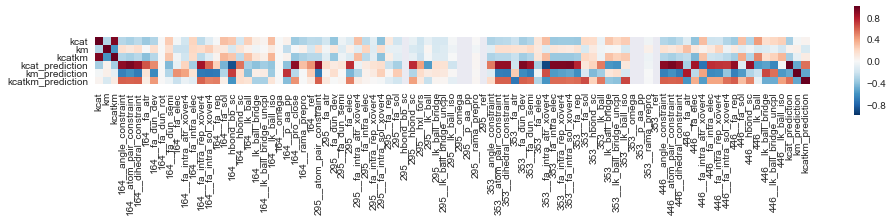

In [31]:
cols = [n for n in J.columns if 'prediction' in n or n in targets]
fig, ax = plt.subplots(figsize=(16, 2))
sns.heatmap(J.corr()[cols].T, ax=ax, square=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x13270b0b8>], dtype=object)

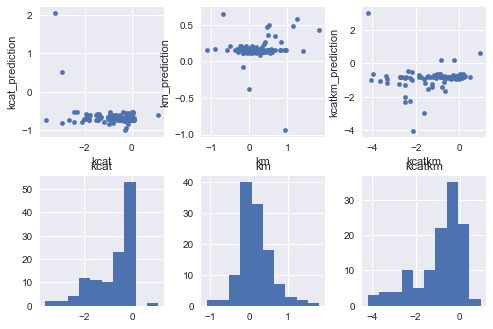

In [32]:
fig, ax = plt.subplots(nrows=2, ncols=3) 
J.plot(x='kcat', y='kcat_prediction', ax=ax[0, 0], kind='scatter')
J.plot(x='km', y='km_prediction', ax=ax[0, 1], kind='scatter')
J.plot(x='kcatkm', y='kcatkm_prediction', ax=ax[0, 2], kind='scatter')
J.hist('kcat', ax=ax[1,0]) 
J.hist('km', ax=ax[1,1]) 
J.hist('kcatkm', ax=ax[1,2]) 